In [5]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as T
from tqdm import tqdm

In [2]:
transform = T.Compose(
    [T.ToTensor(), # tensor 
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # -0.5~0.5 범위로 바꿔주고 , 다시 0.5로 나눠준다(채널별로)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size = 4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset,batch_size = 4, shuffle=False,num_workers=2)

# trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

valloader = torch.utils.data.DataLoader(valset,batch_size = 4, shuffle=False,num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


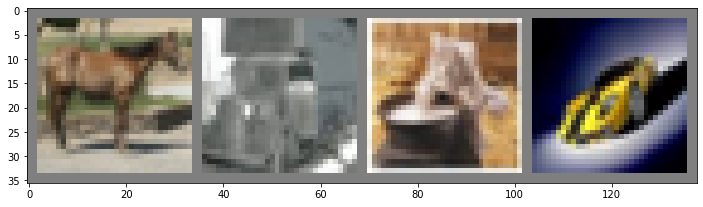

horse truck   cat   car
Image type : <class 'torch.Tensor'>
Image shape: torch.Size([4, 3, 32, 32])
Image type : <class 'torch.Tensor'>
Image shape: torch.Size([4]), tensor([7, 9, 3, 1])


In [19]:
def imshow(img):
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (12,8))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

print(f'Image type : {type(images)}\nImage shape: {images.shape}') ## shape : [batch_size, num_channel(rgb),w,h]
print(f'Image type : {type(labels)}\nImage shape: {labels.shape}, {labels}')

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self,in_dim,out_dim,hid_dim,n_layer,act):
        super(MLP,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.fc = nn.Linear(self.in_dim,self.hid_dim)
        self.linears = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim,self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim,self.out_dim)

        if self.act == 'relu':
            self.act = nn.ReLU()
        else:
            self.act = nn.Sigmoid()
        
    def forward(self, x):
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)
        return x

in_dim = 1024 * 3
out_dim = 10
hid_dim = 100
n_layer = 4 # hidden layer 개수
activation_func = 'relu'
model = MLP(in_dim,out_dim,hid_dim,n_layer,activation_func)
print(model)

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)


In [4]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.001, momentum = 0.9)
print(criterion)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


### Train Code

In [29]:
from tqdm import tqdm
epochs = 2
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.view(-1,3072)
        # print(inputs.shape)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

  0%|          | 0/2 [00:00<?, ?it/s]

[1,  2000] loss: 2.096
[1,  4000] loss: 1.830
[1,  6000] loss: 1.726
[1,  8000] loss: 1.677
[1, 10000] loss: 1.651
[1, 12000] loss: 1.624


 50%|█████     | 1/2 [01:07<01:07, 67.39s/it]

[2,  2000] loss: 1.548
[2,  4000] loss: 1.524
[2,  6000] loss: 1.512
[2,  8000] loss: 1.500
[2, 10000] loss: 1.504
[2, 12000] loss: 1.475


100%|██████████| 2/2 [02:13<00:00, 66.96s/it]

Finished Training


## Val Loss & Accuracy

In [42]:
correct = 0
total = 0
loss_arr = []
val_loss = 0
with torch.no_grad():
    for data in valloader:
        images,labels = data
        images = images.view(-1,3072)
        outputs = model(images)
        loss = criterion(outputs,labels)
        val_loss += loss.item()
        _,predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(valloader)
print(val_loss)
print('Accuracy : {}, val loss : {:.3f}'.format(100 * correct/total, val_loss))

1.4306718767166138
Accuracy : 49.42, val loss : 1.431


### Experiment

In [13]:
def experiment(args):
    model = MLP(args.in_dim,args.out_dim,args.hid_dim,args.n_layer,args.act)
    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(),lr = args.lr,momentum = args.mm)

    for epoch in tqdm(range(args.epoch)):  # loop over the dataset multiple times
        # === Train === #
        running_loss = 0.0
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.view(-1,3072)

            inputs = inputs.cuda()
            labels = labels.cuda()

            # print(inputs.shape)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            train_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        # === validation === #
        correct = 0
        total = 0
        loss_arr = []
        val_loss = 0
        with torch.no_grad():
            for data in valloader:
                images,labels = data
                images = images.view(-1,3072)
                images = images.cuda()
                labels = labels.cuda()

                outputs = model(images)
                loss = criterion(outputs,labels)
                val_loss += loss.item()
                _,predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_loss = val_loss / len(valloader)
            val_acc = 100 * correct/total
            print('Epoch : {}, Train loss : {:.3f}, Val Loss : {:.3f} Val Accuracy : {:.3f}'.format(epoch,train_loss,val_loss,val_acc))
    correct = 0
    total = 0
    loss_arr = []
    test_loss = 0
    with torch.no_grad():
        for data in testloader:
            images,labels = data
            images = images.view(-1,3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss += loss.item()
            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_loss = test_loss / len(testloader)

    print('Accuracy : {}, val loss : {:.3f}'.format(100 * correct/total, val_loss))
    print('Finished Training')


In [14]:
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args("")

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'
args.lr = 0.001
args.mm = 0.9
args.epoch = 2
experiment(args)

  0%|          | 0/2 [00:00<?, ?it/s]

[1,  2000] loss: 2.298
[1,  4000] loss: 2.117
[1,  6000] loss: 1.934
[1,  8000] loss: 1.804
[1, 10000] loss: 1.715


 50%|█████     | 1/2 [00:44<00:44, 44.52s/it]

Epoch : 0, Train loss : 19734.964, Val Loss : 1.683 Val Accuracy : 39.390
[2,  2000] loss: 1.670
[2,  4000] loss: 1.634
[2,  6000] loss: 1.610
[2,  8000] loss: 1.571
[2, 10000] loss: 1.568


100%|██████████| 2/2 [01:30<00:00, 45.04s/it]

Epoch : 1, Train loss : 16106.622, Val Loss : 1.546 Val Accuracy : 44.460


1.5388006622195243
Accuracy : 45.02, val loss : 1.539
Finished Training
